In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.online_portfolio_selection.momentum import *
# import seaborn as sns
import optuna
from mlfinlab.portfolio_optimization import ReturnsEstimators
from mlfinlab.portfolio_optimization import HierarchicalRiskParity
from mlfinlab.online_portfolio_selection import FCORN
import dl_csv
from mlfinlab.portfolio_optimization.herc import HierarchicalEqualRiskContribution
from mlfinlab.online_portfolio_selection.benchmarks import *
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from pycoingecko import CoinGeckoAPI
from datetime import date, datetime
import ccxt as ccxt
from plotly.subplots import make_subplots 

In [2]:
1+1

2

In [3]:
cg = CoinGeckoAPI()
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

In [4]:
binance_api_key = ''
binance_api_secret = ''

In [5]:
# portfolio_coins = ['XRP/USDT', 'EOS/USDT', 'LTC/USDT', 'TRX/USDT', 'ETC/USDT', 'LINK/USDT', 'XLM/USDT', 'ADA/USDT', 'XMR/USDT', 'DASH/USDT', 'ZEC/USDT', 'XTZ/USDT', 'BNB/USDT', 'ATOM/USDT', 'ONT/USDT', 'IOTA/USDT', 'BAT/USDT', 'VET/USDT', 'NEO/USDT', 'QTUM/USDT', 'IOST/USDT', 'THETA/USDT', 'ALGO/USDT', 'ZIL/USDT', 'KNC/USDT', 'ZRX/USDT', 'COMP/USDT', 'OMG/USDT', 'DOGE/USDT']
# , 'iota',  'compound-governance-token', 'qtum', 'kyber-network', 'omisego' 'dogecoin', 
portfolio_coins = ['ethereum', '0x', 'vechain', 'algorand', 'neo', 'ripple', 'eos', 'tron', 'chainlink', 'stellar', 'cardano', 'tezos', 'binancecoin', 'cosmos', 'ontology' ,'iota', 'qtum', 'kyber-network', 'omisego', 'dogecoin', 'zcash', 'theta-token', 'swipe', 'ethlend']

In [6]:
# todays_date = date.today().strftime("%Y-%m-%d")
# from_date = datetime.timestamp(datetime(2020, 1, 1))
# print(from_date)
# datetime.timestamp(date.today())
price_data = cg.get_coin_market_chart_by_id(id=portfolio_coins[-1], vs_currency='btc', days='max')
price_data.keys()
price_data['prices'][-1]


[1595770206000, 2.809159908044548e-05]

In [7]:
for i, row in enumerate(price_data['prices']):
    timestamp = row[0]
    price = row[1]
    timestamp = datetime.utcfromtimestamp(timestamp / 1000)
    row[0] = timestamp
    price_data['prices'][i] = row

price_data['prices'][-1]

[datetime.datetime(2020, 7, 26, 13, 30, 6), 2.809159908044548e-05]

In [8]:

my_dataframe = []
for i, coin in enumerate(portfolio_coins):
    print(coin)
    price_data = cg.get_coin_market_chart_by_id(id=coin, vs_currency='usd', days='max')
    for pdi, row in enumerate(price_data['prices']):
        timestamp = row[0]
        price = row[1]
        timestamp = datetime.utcfromtimestamp(timestamp / 1000)
        row[0] = timestamp
        price_data['prices'][pdi] = row
    current_dataframe = pd.DataFrame.from_records(price_data['prices'], columns=['timestamp', coin])
    current_dataframe.reset_index(drop=True, inplace=True)
    my_dataframe.append(current_dataframe)

my_dataframe[-1].tail()

ethereum
0x
vechain
algorand
neo
ripple
eos
tron
chainlink
stellar
cardano
tezos
binancecoin
cosmos
ontology
iota
qtum
kyber-network
omisego
dogecoin
zcash
theta-token
swipe
ethlend


,timestamp,ethlend
945,2020-07-22 00:00:00,0.303497
946,2020-07-23 00:00:00,0.309326
947,2020-07-24 00:00:00,0.286238
948,2020-07-25 00:00:00,0.309941
949,2020-07-26 06:08:45,0.296731


In [44]:
portfolio_dataframe = my_dataframe[0]
for i, mdf in enumerate(my_dataframe):
    if (i) == 0: continue
    portfolio_dataframe = pd.merge(portfolio_dataframe, mdf, how='inner', on=['timestamp'])

portfolio_dataframe.set_index('timestamp', inplace=True, drop=True)
portfolio_dataframe.index = pd.to_datetime(portfolio_dataframe.index)
# add usdt
portfolio_dataframe['usdt'] = 1.0
portfolio_dataframe.head()

# Up portfolio
# portfolio_dataframe = portfolio_dataframe['2020-01-01': datetime.now().strftime('%Y-%m-%d')]

,ethereum,0x,vechain,algorand,neo,ripple,eos,tron,chainlink,stellar,...,iota,qtum,kyber-network,omisego,dogecoin,zcash,theta-token,swipe,ethlend,usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-08-24,194.209387,0.185271,0.004608,0.574140,9.881347,0.276145,3.676259,0.018001,2.233751,0.068752,...,0.259461,2.601897,0.191961,1.239510,0.002689,50.927342,0.128641,0.240301,0.003887,1.0
2019-08-25,190.555751,0.184606,0.004891,0.575261,10.102062,0.268682,3.657661,0.017796,2.169630,0.067670,...,0.258942,2.547838,0.168318,1.263472,0.002619,50.055071,0.129589,0.247109,0.003822,1.0
2019-08-26,186.322369,0.179055,0.004478,0.541431,9.652930,0.269789,3.550808,0.017632,2.074527,0.071503,...,0.264780,2.533653,0.185565,1.234888,0.002678,50.048812,0.123823,0.238814,0.003899,1.0
2019-08-27,188.377257,0.177819,0.004559,0.520963,9.824421,0.269654,3.578496,0.017694,2.069976,0.069996,...,0.268885,2.530861,0.186879,1.223104,0.002643,51.490283,0.121019,0.237351,0.004346,1.0
2019-08-28,186.970685,0.172247,0.004529,0.523193,9.572306,0.269445,3.542609,0.017624,2.109661,0.068378,...,0.260733,2.470827,0.189200,1.173641,0.002622,50.536012,0.128065,0.229302,0.004349,1.0


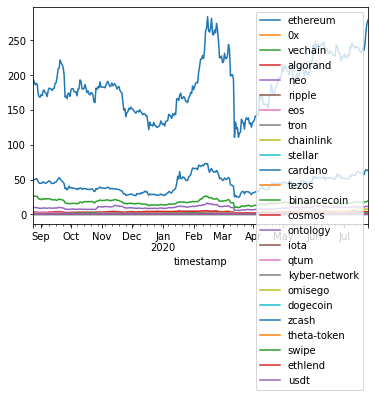

In [45]:

portfolio_dataframe.plot()

In [11]:
# study = optuna.create_study(study_name="pm", storage='sqlite:///example.db', direction='maximize')


In [12]:
# study = optuna.delete_study(study_name="pm", storage='sqlite:///example.db')

In [46]:
study = optuna.load_study(study_name="pm", storage='sqlite:///example.db')

In [47]:
def obj(trial):
    window = trial.suggest_int('window', 1, 30)
    rho = trial.suggest_uniform('rho', 0, 1)
    lambd = trial.suggest_uniform('lambd', 0, 1)
    temp = FCORN(window, rho, lambd)
    temp.allocate(portfolio_dataframe, verbose=True)

    data_len, period = portfolio_dataframe.shape[0], 10
    for i in range(0, period):
        time = data_len * i // period
        trial.report(temp.portfolio_return.iloc[time][0], step=time)

    return temp.portfolio_return.iloc[-1][0]

In [48]:
number = 10
study.optimize(obj, n_trials=number)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-26 14:57:37,064] Finished trial#40 with value: 2.038602445759167 with parameters: {'window': 30, 'rho': 0.9163355153971237, 'lambd': 0.4329065767754144}. Best is trial#36 with value: 24.915111212675374.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-26 14:57:38,953] Finished trial#41 with value: 18.011030055841537 with parameters: {'window': 25, 'rho': 0.8321367509373311, 'lambd': 0.3041506347707884}. Best is trial#36 with value: 24.915111212675374.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-26 14:57:40,896] Finished trial#42 with value: 28.790640734911943 with parameters: {'window': 28, 'rho': 0.9199968087654651, 'lambd': 0.372177395349914}. Best is trial#42 with value: 28.790640734911943.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
[I 2020-07-26 14:57:42,991] Finished tria

In [49]:
# study_df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
print("Best window parameter: ", study.best_params['window'])
print("Best lambd parameter: ", study.best_params['lambd'])
print("Best rho parameter: ", study.best_params['rho'])
print("Best returns: ", study.best_trial.value)
print("Best trial number: ", study.best_trial.number)

Best window parameter:28
Best lambd parameter:0.3729071770232738
Best rho parameter:0.6196342741394636
Best returns:29.663669709733075
Best trial number:48


In [50]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(title_text="Crpto FCORN for Lambd of [0, 1], Rho of [, 1], and Window of [1, 30]", yaxis_title_text="Relative Returns")
display(fig)

In [51]:
pm = FCORN(window=study.best_params['window'], rho=study.best_params['rho'], lambd=study.best_params['lambd'])
# mu = EG(update_rule='MU', eta=2)
# portfolio_dataframe = portfolio_dataframe.drop(columns=['swipe'])
pm.allocate(asset_prices=portfolio_dataframe, verbose=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [74]:
pm.all_weights.tail(3)
# pm.all_weights['2020-03-11':]
# Find all times portfolio went flat 0_o
# pm.all_weights.loc[pm.all_weights['usdt'] == 1].tail(10)

,ethereum,0x,vechain,algorand,neo,ripple,eos,tron,chainlink,stellar,...,iota,qtum,kyber-network,omisego,dogecoin,zcash,theta-token,swipe,ethlend,usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2020-07-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2020-07-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
current_optimised_weightings = pm.all_weights.tail(1)

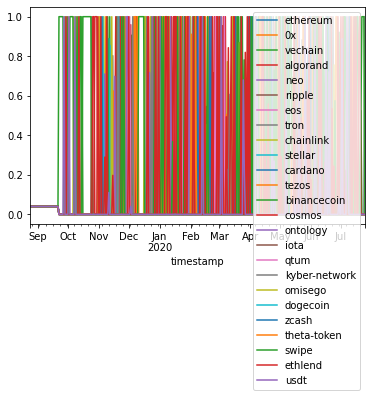

In [54]:
pm.all_weights.plot()

In [55]:
print(pm.portfolio_return['Returns'].head(1))
pm.portfolio_return['Returns'].tail()

timestamp
2019-08-24    1.0
Name: Returns, dtype: float64


timestamp
2020-07-21    30.650911
2020-07-22    30.665040
2020-07-23    28.438939
2020-07-24    30.114527
2020-07-25    29.663670
Name: Returns, dtype: float64

In [56]:
fig = go.Figure()
idx = pm.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=pm.portfolio_return['Returns'], name="PM"))
fig.update_layout(title='Pattern Matching Strategy on Crypto', xaxis_title='Date', yaxis_title='Relative Returns')
fig.show()

In [57]:
pm.weights

array([8.24105743e-16, 0.00000000e+00, 1.11203727e-15, 0.00000000e+00,
       0.00000000e+00, 5.89136163e-16, 4.08814348e-16, 0.00000000e+00,
       5.27355937e-16, 5.58583170e-16, 0.00000000e+00, 1.50788692e-16,
       0.00000000e+00, 2.47002768e-16, 2.39095609e-16, 0.00000000e+00,
       7.31656889e-17, 1.00000000e+00, 6.76111429e-16, 1.56416665e-16,
       1.17475720e-16, 0.00000000e+00, 1.52340629e-15, 0.00000000e+00,
       0.00000000e+00])

In [58]:
pm.relative_return[-1]

array([1.01712061, 0.99196639, 0.98064761, 0.95201048, 0.97004396,
       0.98131329, 0.97851235, 1.00624203, 0.94306577, 0.9772079 ,
       0.98313821, 0.95789483, 1.0265001 , 0.96470029, 0.97162305,
       0.95756227, 0.97352397, 0.98502858, 0.96323446, 0.97804002,
       0.9915395 , 0.97208472, 1.21857401, 1.08280896, 1.        ])

In [59]:
pm.asset_prices.tail()

,ethereum,0x,vechain,algorand,neo,ripple,eos,tron,chainlink,stellar,...,iota,qtum,kyber-network,omisego,dogecoin,zcash,theta-token,swipe,ethlend,usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-21,236.060098,0.396525,0.016166,0.360348,10.401539,0.194670,2.561687,0.017198,7.264518,0.094623,...,0.249971,2.230066,1.635956,1.626230,0.003234,56.987167,0.236774,1.657820,0.317981,1.0
2020-07-22,245.233735,0.399719,0.017531,0.345941,11.172521,0.199050,2.620684,0.017638,7.292423,0.096299,...,0.265203,2.351128,1.660447,1.649866,0.003305,62.243672,0.238394,1.658584,0.303497,1.0
2020-07-23,263.762464,0.399430,0.017509,0.346173,11.573522,0.203438,2.659182,0.017959,7.477310,0.097281,...,0.277666,2.385387,1.643451,1.727273,0.003283,64.168015,0.254840,1.538180,0.309326,1.0
2020-07-24,274.723620,0.390025,0.017327,0.328571,11.427525,0.208187,2.650973,0.017870,7.873266,0.097965,...,0.278640,2.351060,1.603470,1.684822,0.003296,63.473777,0.257990,1.628808,0.286238,1.0
2020-07-25,279.427056,0.386892,0.016992,0.312803,11.085202,0.204297,2.594009,0.017981,7.425008,0.095732,...,0.266816,2.288813,1.579464,1.622878,0.003224,62.936757,0.250788,1.984823,0.309941,1.0


Progress: |██████████████████████████████████████████████████| 100.0% Complete
timestamp
2020-07-25    5.158244
Name: Returns, dtype: float64


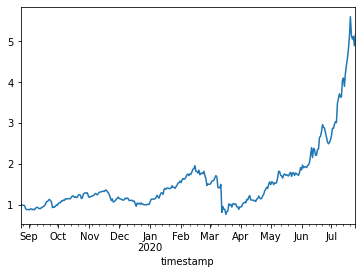

In [60]:
bah = BAH()
bah.allocate(asset_prices=portfolio_dataframe, verbose=True)
print(bah.portfolio_return['Returns'].tail(1))
bah.portfolio_return['Returns'].plot()

In [61]:

fig = go.Figure()
idx = pm.portfolio_return.index
fig.add_trace(go.Scatter(x=idx, y=bah.portfolio_return['Returns'], name="Buy and Hold"))
fig.add_trace(go.Scatter(x=idx, y=pm.portfolio_return['Returns'], name="FCORN"))
fig.update_layout(title='Pattern Matching Strategies on Crypto', xaxis_title='Date', yaxis_title='Relative Returns', yaxis_type="log")
fig.show()

In [29]:
exchange = ccxt.binance({
    "apiKey": binance_api_key,
    "secret": binance_api_secret,
    'enableRateLimit': True,
})
exchange.options['defaultType'] = 'future'

In [30]:
markets = exchange.load_markets(True)
markets.keys()
# ['BTC/USDT', 'ETH/USDT', 'BCH/USDT', 'XRP/USDT', 'EOS/USDT', 'LTC/USDT', 'TRX/USDT', 'ETC/USDT', 'LINK/USDT', 'XLM/USDT', 'ADA/USDT', 'XMR/USDT', 'DASH/USDT', 'ZEC/USDT', 'XTZ/USDT', 'BNB/USDT', 'ATOM/USDT', 'ONT/USDT', 'IOTA/USDT', 'BAT/USDT', 'VET/USDT', 'NEO/USDT', 'QTUM/USDT', 'IOST/USDT', 'THETA/USDT', 'ALGO/USDT', 'ZIL/USDT', 'KNC/USDT', 'ZRX/USDT', 'COMP/USDT', 'OMG/USDT', 'DOGE/USDT']

dict_keys(['BTC/USDT', 'ETH/USDT', 'BCH/USDT', 'XRP/USDT', 'EOS/USDT', 'LTC/USDT', 'TRX/USDT', 'ETC/USDT', 'LINK/USDT', 'XLM/USDT', 'ADA/USDT', 'XMR/USDT', 'DASH/USDT', 'ZEC/USDT', 'XTZ/USDT', 'BNB/USDT', 'ATOM/USDT', 'ONT/USDT', 'IOTA/USDT', 'BAT/USDT', 'VET/USDT', 'NEO/USDT', 'QTUM/USDT', 'IOST/USDT', 'THETA/USDT', 'ALGO/USDT', 'ZIL/USDT', 'KNC/USDT', 'ZRX/USDT', 'COMP/USDT', 'OMG/USDT', 'DOGE/USDT', 'SXP/USDT', 'LEND/USDT'])

In [62]:
current_balances = exchange.fetch_balance()
current_owned_coins = []

for (key, value) in current_balances.items():
    if (key == 'total'):
        for (coin, balance) in value.items():
            if (balance > 0):
                current_owned_coins.append({ coin: balance })

print(current_owned_coins)

[{'USDT': 11.34533395}]


In [63]:
current_optimised_weightings

,ethereum,0x,vechain,algorand,neo,ripple,eos,tron,chainlink,stellar,...,iota,qtum,kyber-network,omisego,dogecoin,zcash,theta-token,swipe,ethlend,usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
